In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

# Bond Sensitivities with Automatic Differentiation
## Introduction to the Reverse Mode of Automatic Differentiation
One common use case for Reverse Mode Automatic Differentiation is the computation of interest rate sensitivities. Practitioners are interested in the effect of shifts and rotations of an interest rate curve. Often, the individual sensitivities of particular maturities are of paramount importance, for example for hedging purposes.

In those cases where the computation of the effect of parallel shifts is not sufficient, the number of derivatives computed corresponds to the number of maturities of interest.
-  For numerical differentiation, this requires one full function evaluation per derivative
-  Reverse Mode Automatic Differentiation can solve this problem in less than 10 times the runtime of the function evaluation for arbitrary numbers of sensitivities (with theoretical performance of 4-5 times the time of a single function evaluation)

This use case is illustrated in the following. First, lets revisit the numerical differentiator as well as the required tools for Reverse Mode Automatic Differentiation.

Numerical differentiation simply perturbs the function of interest with respect to the argument that should be evaluated in terms of its marginal contribution:

In [2]:
def numerical_differentiation(function,x):
    h = 1e-7
    return (function(x+h)-function(x))/h

The dual numbers for Reverse Mode Automatic Differentiation are defined in the following. For this custom number type, elementary operations like addition and multiplication are defined. In addition, elementary functions like the natural log are overloaded to perform Automatic Differentiation:

In [3]:
class dual_number_reverse:
    def __init__(self,value,adjoint=()):
        self.value = value
        self.adjoint = adjoint
    
    def __add__(self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value + other.value
            
            c.adjoint = ((self, 1), (other, 1))
            
            return c
            
    def __sub__(self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value - other.value
            
            c.adjoint = ((self, 1),(other, -1))    
            return c  
            
    def __mul__ (self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value * other.value
            
            c.adjoint = ((self, other.value),(other, self.value))
            
            return c
            
    def __truediv__ (self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value / other.value
            
            c.adjoint = ((self, 1/ other.value),(other, - self.value/other.value**2) )
            
            return c
        else:
            c = dual_number_reverse(None,None)
            
            c.value = self.value / other
            
            c.adjoint = ((self, 1/ other),)
            
            return c
    def __pow__(self, other):
            c = dual_number_reverse(None,None)
            
            c.value = self.value ** other.value
            
            c.adjoint = ((self, other.value*(self.value**(other.value-1)) ),(other, self.value*other.value*log(self.value)) )
            
            return c

In [4]:
def sqrt(x):
    if type(x)==dual_number_reverse:
        temp = dual_number_reverse(None,None)
        
        temp.value = np.sqrt(x.value)
        
        temp.adjoint = ( (x,0.5*(1 / x.value ** 0.5)),)
        
        return temp
    else:
        return np.sqrt(x)
    
def cdf(x):
    if type(x)==dual_number_reverse:
        
        temp = dual_number_reverse(None,None)
        
        temp.value =  norm.cdf(x.value)
        
        temp.adjoint = ((x, norm.pdf(x.value)),)
        
        return temp

     
    else: 
        return norm.cdf(x)    

def log(x):
    if type(x)==dual_number_reverse:
        temp = dual_number_reverse(None,None)
        
        temp.value =  np.log(x.value)
        
        temp.adjoint = ((x, 1.0/x.value),)
        
        return temp

    else: 
        return np.log(x)    

The elementary operations of the dual numbers take care of the procedure of "taping", keeping track of all operations performed and building up a computational graph in form of a python dictionary. This dictionary logs intermediate results as well as the children nodes of each operation (meaning the result of a elementary operation is saved and related to its input values in the computational graph). This dictionary needs a tape interpreter that propagates through the graph and accumulates the gradient information:

In [5]:
def get_gradients(variable):

    gradients = defaultdict(lambda: 0)
    
    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.adjoint:
          
            value_of_path_to_child = path_value * local_gradient
          
            gradients[child_variable] += value_of_path_to_child
           
            compute_gradients(child_variable, value_of_path_to_child)
    
    compute_gradients(variable, path_value=1)

    return gradients

Now, arithmetic operations can be performed with such dual numbers:

In [6]:
a = dual_number_reverse(2)
b = dual_number_reverse(5)

In [7]:
c = a**b

In [8]:
c

In [9]:
c_gradient = get_gradients(c)

We can test whether the resulting derivative is the expected value, based on a manual symbolic differentiation of the function $c=a^b$. The expected derivative is therefore $c'=b*a^{b-1}$, such that for $a=2$ and $b=5$, the expression evaluates as 80.

In [10]:
print(5*a.value**4)
c_gradient[a]


80


80

## Use case: Bond pricing and sensitivity computation

A coupon bond with annual payment and a maturity of 50 years will be studied in the following. Formally,
- Coupon rate: $c_t=5\%$ for all $t$
- Current time: $t=0$
- Tenor of the bond: $T$
- Discount curve at maturity $t$: $r_t$
- Nominal: $N=100$

The yearly coupon payment is, as a result, $c_t*N=C_t$, and the nominal is paid back in the final period. For the sake of simplicity, the fair value of the bond is priced at $t=0$ and the first coupon payment is made at $t=1$.

Lets assume that the appropriate discount curve is given by the following values:



In [11]:
discount_curve = [np.log(x) for x in range(1,51)]

**Note**: The following example makes very idealistic simplifications to instructively demonstrate the workings of Automatic Differentiation. Therefore, a direct discount curve is assumed, although in practice this curve may itself be subject to the risk factors one is interested in such that in practice the sensitivity is not directly computed based on the discount curve but e.g. on underlying macro parameters.

This corresponds to a typical shape of a discount curve, which can be visualized as followed:

Text(0.5, 0, 'Maturity corresponding to rate')

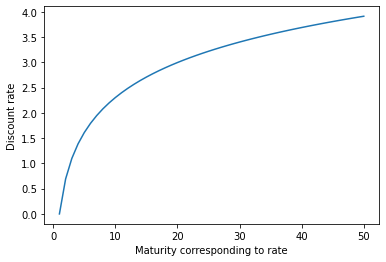

In [12]:
Figure = plt.figure()
ax = plt.axes()
plt.plot(range(1,51),discount_curve)
ax.set_ylabel("Discount rate")
ax.set_xlabel("Maturity corresponding to rate")

The considered curve starts with low interest rates for the near future and increases with decreasing speed. A bond price will then be given by the sum of the discounted cashflows:

In [13]:
cashflow_bond = [5 for _ in range(1,50)]
cashflow_bond.append(105)
maturity_cashflows = [x for x in range(1,51)]

The bond price results as the discounted sum of cashflows, where the appropriate discount rate is applied to each cashflow:

In [14]:
def bond_price(discount_curve,cashflow_bond,maturity_cashflows):
    number_payments = len(cashflow_bond)
    temp_present_value = 0
    for i in range(0,number_payments):
        temp_present_value+=cashflow_bond[i]/(1+discount_curve[i]/100)**maturity_cashflows[i]
        
    return temp_present_value

The resulting price for the given bond is given by:

In [15]:
bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)

138.94416773801038

To compute the sensitivities of the bond with respect to each maturity of the discount curve, each discount factor that is used for the calculation needs to be perturbed separately when using numerical differentiation. This requires 50 separate derivatives to be computed.

In [16]:
start = time.time()
list_sensitivities_numerical_differentiation= []
base_price_bond = bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)

h = 1e-8
    
for i in range(0,len(discount_curve)):
    base_bond_test = bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)
    h = 1e-8
    discount_curve_test = discount_curve
    discount_curve_test[i]= discount_curve_test[i]+h
    bond_sensitivity = (bond_price(discount_curve=discount_curve_test,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)-base_bond_test)/h
    list_sensitivities_numerical_differentiation.append(bond_sensitivity)
end = time.time()
print(f"Runtime of the program is {round(1000*(end - start),3)}ms")

Runtime of the program is 3.954ms


This runtime will be later compared against Reverse Mode Automatic Differentiation. The resulting sensitivities can be graphically shown as:

Text(0.5, 0, 'Maturity corresponding to sensitivity')

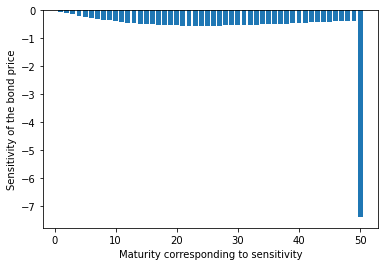

In [17]:
Figure = plt.figure()
ax = plt.axes()
plt.bar(range(1,51),list_sensitivities_numerical_differentiation)
ax.set_ylabel("Sensitivity of the bond price")
ax.set_xlabel("Maturity corresponding to sensitivity")

## Using the Reverse Mode to speed up sensitivity calculations

Since the pricing function was evaluated once per considered discount factor, a method that exhibits a runtime that does not scale linearly with the number of sensitivities would be beneficial. The Reverse Mode performs the same computation in constant time, which will be demonstrated in the following.

For convenience, we define the pricing function in a way that all numbers used are dual numbers. That allows us to perform the same calculations without introducing further arithmetic rules.

In [18]:
def bond_price_reverse(discount_curve,cashflow_bond,maturity_cashflows):
    
    temp_present_value = dual_number_reverse(0)
    number_payments=len(cashflow_bond)
    constant_1=dual_number_reverse(1)
    constant_100=dual_number_reverse(100)
    
    for i in range(0,number_payments):
        temp_present_value=temp_present_value+cashflow_bond[i]/(constant_1+discount_curve[i]/constant_100)**maturity_cashflows[i]      
    
    return temp_present_value

As our function input, all discount rates, cashflows and maturity time stamps are transformed to the dual number format.

In [19]:
discount_curve_dual_numbers = []
for i in range(1,51):
    value_discount_curve=discount_curve[i-1]
    discount_curve_dual_numbers.append(dual_number_reverse(value_discount_curve))
    
cashflow_bond_dual_numbers = []
for i in range(1,51):
    value_cashflow_bond=cashflow_bond[i-1]
    cashflow_bond_dual_numbers.append(dual_number_reverse(value_cashflow_bond))

maturity_cashflows_dual_numbers = []
for i in range(1,51):
    value_maturity_cashflows=maturity_cashflows[i-1]
    maturity_cashflows_dual_numbers.append(dual_number_reverse(value_maturity_cashflows))

Using the dual number formulation, the bond price can now be computed:

In [20]:
dual_number_price = bond_price_reverse(discount_curve=discount_curve_dual_numbers,cashflow_bond=cashflow_bond_dual_numbers,maturity_cashflows=maturity_cashflows_dual_numbers)

The bond prices must coincide with the standard formula, which can be demonstrated as followed:

In [21]:
bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)

138.94416745167055

In [22]:
dual_number_price.value

138.94416745167055

Since the sensitivities are the main objects of interest, the tape interpreter is called to obtain accumulated gradients for each individual calculation step:

In [23]:
gradients = get_gradients(dual_number_price)
gradients

defaultdict(<function __main__.get_gradients.<locals>.<lambda>()>,
            {<__main__.dual_number_reverse at 0x15fd07c3358>: 1,
             <__main__.dual_number_reverse at 0x15fd07c3240>: 1,
             <__main__.dual_number_reverse at 0x15fd07c3128>: 1,
             <__main__.dual_number_reverse at 0x15fd07bbfd0>: 1,
             <__main__.dual_number_reverse at 0x15fd07bbeb8>: 1,
             <__main__.dual_number_reverse at 0x15fd07bbda0>: 1,
             <__main__.dual_number_reverse at 0x15fd07bbc88>: 1,
             <__main__.dual_number_reverse at 0x15fd07bbb70>: 1,
             <__main__.dual_number_reverse at 0x15fd07bba58>: 1,
             <__main__.dual_number_reverse at 0x15fd07bb940>: 1,
             <__main__.dual_number_reverse at 0x15fd07bb828>: 1,
             <__main__.dual_number_reverse at 0x15fd07bb710>: 1,
             <__main__.dual_number_reverse at 0x15fd07bb5f8>: 1,
             <__main__.dual_number_reverse at 0x15fd07bb4e0>: 1,
             <__main__.

For each variable in our discount curve, the **gradients** dictionary holds the gradients of each dual number. We can explicitly ask the **gradients** dictionary for the references of our discount curve variables, to get the final sensitivities:

In [24]:
reverse_mode_sensitivities = [gradients[discount_curve_dual_numbers[x]] for x in range(0,50)]

The computed sensitivities look as followed:

In [25]:
reverse_mode_sensitivities

[-0.04999999999,
 -0.09794905601455454,
 -0.14358546580402115,
 -0.1866954549926753,
 -0.2271620163212938,
 -0.2649310776136178,
 -0.2999919382571257,
 -0.33236510582184137,
 -0.36209414078490915,
 -0.3892398665888643,
 -0.41387608105664697,
 -0.4360862783042106,
 -0.45596108361745413,
 -0.4735962109566523,
 -0.4890908156877428,
 -0.5025461539230167,
 -0.5140644847638631,
 -0.5237481683224922,
 -0.5316989237930673,
 -0.5380172198909322,
 -0.5428017758065373,
 -0.5461491551357147,
 -0.5481534385079762,
 -0.5489059631424675,
 -0.5484951195229683,
 -0.5470061969409991,
 -0.5445212709099208,
 -0.5411191264747924,
 -0.536875212284986,
 -0.5318616209978533,
 -0.526147092170996,
 -0.519797034300005,
 -0.512873563084653,
 -0.5054355533727515,
 -0.4975387025472257,
 -0.48923560339697814,
 -0.4805758247519895,
 -0.47160599837332656,
 -0.4623699107735532,
 -0.45290859880617,
 -0.44326044800668063,
 -0.4334612927957314,
 -0.42354451776807345,
 -0.4135411593918804,
 -0.4034800075326356,
 -0.3933877

One must ensure that the sensitivities of both procedures of differentiation coincide. To verify this visually, the differences between numerical differentiation and Automatic Differentiation can be shown:

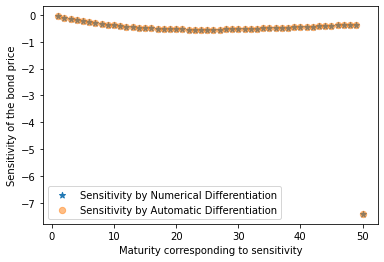

In [26]:
Figure = plt.figure()
ax = plt.axes()
plt.scatter(range(1,51),list_sensitivities_numerical_differentiation,label="Sensitivity by Numerical Differentiation", s=40, alpha=1,marker="*")
plt.scatter(range(1,51),reverse_mode_sensitivities,label="Sensitivity by Automatic Differentiation", s=40, alpha=0.5)
ax.set_ylabel("Sensitivity of the bond price")
ax.set_xlabel("Maturity corresponding to sensitivity")
plt.legend()

It becomes apparent that the computed sensitivities are identical. To justify the additional complexity of the Reverse Mode, we should expect the runtime to improve drastically, which is analyzed next.

## Runtime comparison between modes of differentiation

To make sure that the runtime numbers are reliable, 1000 repetitions of the following operations are performed and averaged:
- Reverse Mode sensitivities
- Numerical differentiation sensitivities
- Time to evaluate the base pricing function once

Under ideal practical circumstances, we expect the Reverse Mode to consume around 5-10 times more time than one base function evaluation (in theory the procedure guarantees 4-4.5 times the complexity of one function evaluation). The numerical differentiation evaluates the function once per derivative, hence the expected runtime is around 50 times of the base function runtime.

In practice and without much code optimizations, the performance numbers will deviate from the optimal practical as well as theoretical bounds.

In [27]:
def timereps(reps, func):
    start = time.time()
    for i in range(0, reps):
        func()
    end = time.time()
    return np.round(1000*(end - start) / reps,3)

def reverse_mode_time_measurement():
    dual_number_price = bond_price_reverse(discount_curve=discount_curve_dual_numbers,cashflow_bond=cashflow_bond_dual_numbers,maturity_cashflows=maturity_cashflows_dual_numbers)
    gradients = get_gradients(dual_number_price)

h = 1e-8
def numerical_time_measurement():
    list_sensitivities_numerical_differentiation= []
    base_price_bond = bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)
    
    for i in range(0,len(discount_curve)):
        base_bond_test = bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)
   
        discount_curve_test = discount_curve
        discount_curve_test[i]= discount_curve_test[i]+h
        bond_sensitivity = (bond_price(discount_curve=discount_curve_test,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)-base_bond_test)/h
        list_sensitivities_numerical_differentiation.append(bond_sensitivity)

def base_time_measurement():
    bond_price(discount_curve=discount_curve,cashflow_bond=cashflow_bond,maturity_cashflows=maturity_cashflows)    

In [28]:
reps = 1000
base_function_runtime_avg = timereps(reps,base_time_measurement)
reverse_runtime_avg = timereps(reps, reverse_mode_time_measurement)
numerical_runtime_avg = timereps(reps, numerical_time_measurement)
print(r"The base function evaluation runtime averaged over {} repetitions is {}ms".format(reps,base_function_runtime_avg))
print(r"The Reverse Mode runtime averaged over {} repetitions is {}ms".format(reps,reverse_runtime_avg))
print(r"The numerical differentiation runtime averaged over {} repetitions is {}ms".format(reps,numerical_runtime_avg))

The base function evaluation runtime averaged over 1000 repetitions is 0.055ms
The Reverse Mode runtime averaged over 1000 repetitions is 0.851ms
The numerical differentiation runtime averaged over 1000 repetitions is 4.065ms


In [29]:
print(r"The Reverse Mode runtime is around {} times of one base function evaluation".format(round(reverse_runtime_avg/base_function_runtime_avg,2)))
print(r"The numerical differentiation runtime is around {} times of one base function evaluation".format(round(numerical_runtime_avg/base_function_runtime_avg,2)))

The Reverse Mode runtime is around 15.47 times of one base function evaluation
The numerical differentiation runtime is around 73.91 times of one base function evaluation


It can be seen that the Reverse Mode takes only **one forth** to **one fifth** of the time required to perform numerical differentiation. Therefore, for the purpose of high-dimensional sensitivity calculations, Automatic Differentiation a very efficient way to perform the desired computations.